<a href="https://colab.research.google.com/github/ryanharvey1/teamA-grebes-NMA2020/blob/master/trace_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# trace example 

Made to make example plots that demonstrate speed tuning 

## lets get some figure settings and import some packages

In [41]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

plt.rcParams.update({'font.size': 15})
%config InlineBackend.figure_format = 'retina'
import sys
import pandas as pd  
import numpy as np 
from scipy import stats  
from itertools import compress
import os, requests
from google.colab import files

## Okay, now lets get the data

In [2]:
print('loading data from osf...')
fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())  

loading data from osf...
dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


## lets get some more data that was generated in the speed_cells notebook

In [ ]:
print('loading speed tuning data...')
speed_map = np.load('/content/drive/My Drive/nma_data/6163622_v6/speed_map.npy')
df = pd.read_pickle("/content/drive/My Drive/nma_data/6163622_v6/speed_df.pkl")
df

loading speed tuning data...


,speed_cor,speed_cor_pvalue,slope,intercept,speed_mod,speed_mod_pvalue
0,0.037081,0.031873,[[0.04655153712639664]],[6.701278006979309],0.029077431,0.059761
1,-0.015747,0.119522,[[-0.008001666373229879]],[5.433671749085655],0.010097089,0.274900
2,-0.008763,0.454183,[[-0.0073181789721904495]],[4.6965754671733455],0.010708806,0.159363
3,0.196378,0.003984,[[0.06816048084295674]],[8.474296393925272],0.16257545,0.035857
4,0.008459,0.278884,[[0.08151148078289507]],[13.27337580967431],0.009054725,0.390438
...,...,...,...,...,...,...
11978,-0.028630,0.007968,[[-0.31601890375345476]],[86.03674125511317],0.0073964316,0.561753
11979,0.009240,0.557769,[[-0.020151207141361857]],[35.48008323940126],0.024111908,0.003984
11980,-0.031522,0.031873,[[-0.010835917051686884]],[32.71565770394717],0.017061893,0.207171
11981,-0.000512,0.968127,[[-0.16513455051549225]],[53.14822019287467],0.0088076275,0.266932


## locate some example cells that show nice speed tuning

In [ ]:
row = range(len(df))

idx = (df.speed_cor > 0.4) & (df.speed_mod > 0.5) & (df.speed_cor_pvalue < 0.05) & (df.speed_mod_pvalue < 0.05)

print(list(compress(row,idx)))

idx = (df.speed_cor < -0.2) & (df.speed_mod > 0.1) & (df.speed_cor_pvalue < 0.05) & (df.speed_mod_pvalue < 0.05)

print(list(compress(row,idx)))

[1373, 6472]
[455, 1680, 2963, 5491, 6897]


## Here is a great function that can give you start and end times of where your variable is greater than a given threshold

In [ ]:
def find_groups(x,thres):
  x = x > thres
  x = x[:,0]*1
  x = np.hstack((0,x))

  #locate number of groups
  ngroups=sum(np.diff(x)==1);

  #locate start of group
  x_ind = np.arange(0,len(x)-1,1)
  start = x_ind[np.diff(x)==1][0:-1] - 1

  #locate end of group
  x_ind = np.arange(0,len(x)-1,1)
  ends = x_ind[np.diff(x)==-1]

  return start,ends

## Okay, now we are ready to generate a nice looking figure showing a positive and negatively speed modulated cell 

The red bands indicate running epochs

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

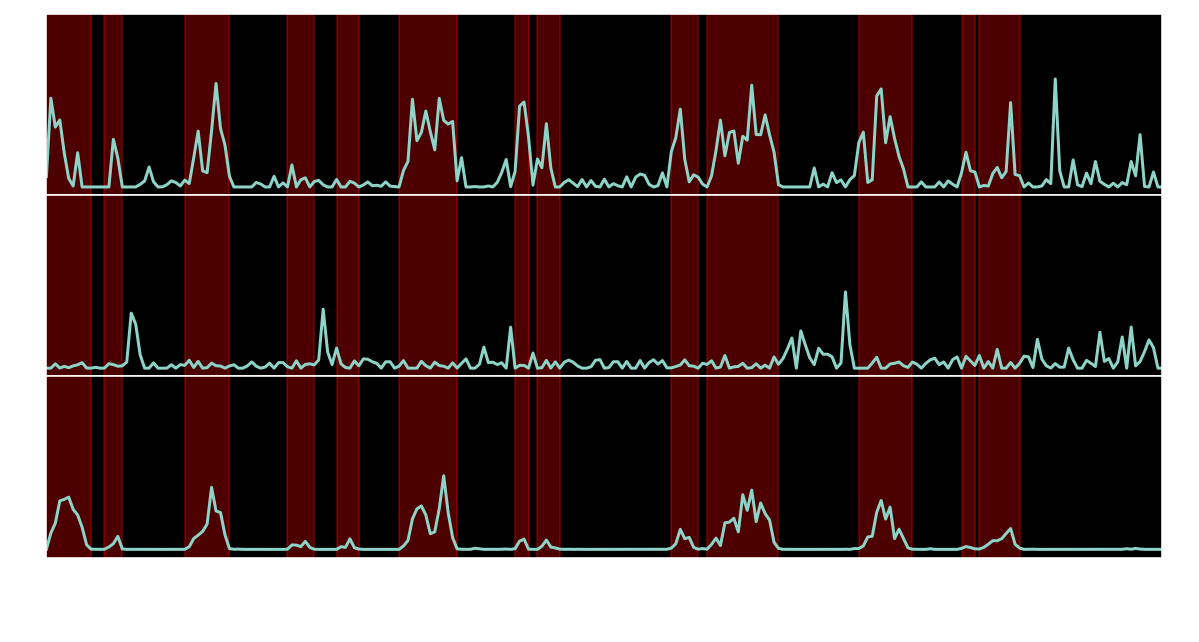

In [ ]:
duration = int(200)
ts = np.arange(0,len(dat['run'])*1.2,1)

start,ends = find_groups(dat['run'],0.5)

fig, axs = plt.subplots(3,1, figsize=(10,5), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=0.1)


axs[0].plot(ts,dat['sresp'][1373])
axs[0].get_yaxis().set_ticks([])
axs[0].set_ylabel('$\Delta F / F$')
axs[0].get_xaxis().set_ticks([])

for i in range(len(start)):
    axs[0].axvspan(start[i], ends[i],
                alpha=0.3, color='red', zorder=-1000)  
axs[0].set_xlim((0,250))

axs[1].plot(ts,dat['sresp'][2963])
axs[1].get_yaxis().set_ticks([])
axs[1].set_ylabel('$\Delta F / F$')
axs[1].get_xaxis().set_ticks([])

for i in range(len(start)):
    axs[1].axvspan(start[i], ends[i],
                alpha=0.3, color='red', zorder=-1000)  
axs[1].set_xlim((0,250))

axs[2].plot(ts,dat['run'])
axs[2].set_ylabel('running')
axs[2].get_yaxis().set_ticks([])
plt.xlabel('time (sec)')

for i in range(len(start)):
    axs[2].axvspan(start[i], ends[i],
                alpha=0.3, color='red', zorder=-1000)  
axs[2].set_xlim((0,250))

fig.savefig("v1_runing_example.png",dpi=600,transparent=True)
files.download("v1_runing_example.png")

In [27]:
def get_speed_map(speed,fr):
  speed_vec = np.arange(min(speed),np.percentile(speed,95),2)

  fr_speed_maps = []
  sem = []
  # get mean firing rate in each speed bin
  for j in range(len(speed_vec)-1):
    start = speed_vec[j]
    stop = speed_vec[j+1]

    idx = [speed > start] and [speed < stop]
    fr_speed_maps.append(np.mean(fr[tuple(idx)]))

    sem.append(np.std(fr[tuple(idx)]) / np.sqrt(len(fr[tuple(idx)])))
  return fr_speed_maps, sem

run = np.squeeze(dat['run'])
cells,time = dat['sresp'].shape

speed_map = []
sem =[]
for i in range(cells):
  fr_speed_maps,sem_ = get_speed_map(run,dat['sresp'][i,:])  
  speed_map.append((fr_speed_maps))
  sem.append((sem_))

## lets check out those speed tuning curves

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

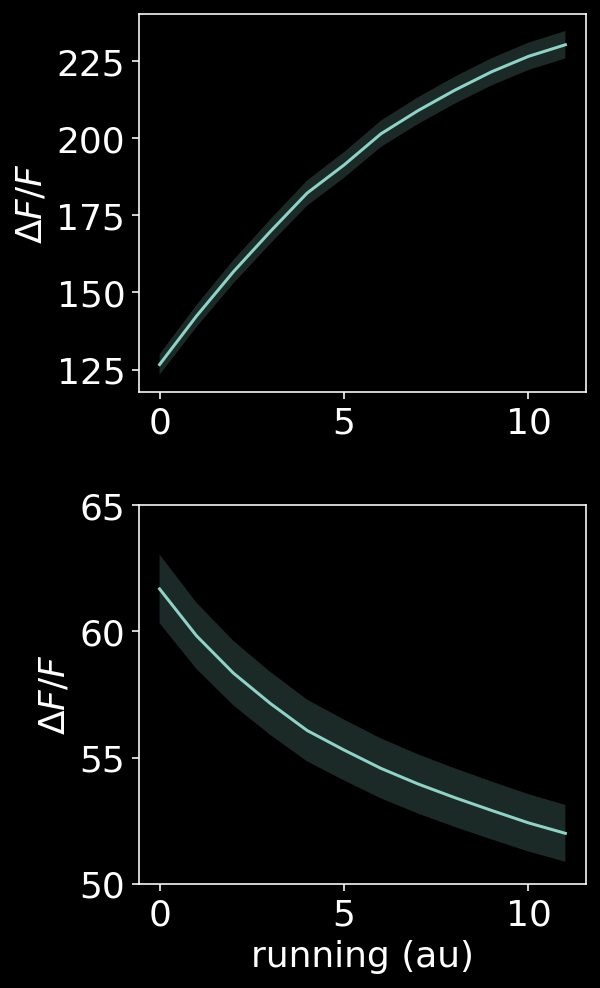

In [65]:
fig, axs = plt.subplots(2,1, figsize=(4,8), edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.1)

x = np.arange(0,len(speed_map[0]),1)

axs[0].plot(x,speed_map[1373])
axs[0].fill_between(x, np.array(speed_map[1373])-np.array(sem[1373]),
                 np.array(speed_map[1373])+np.array(sem[1373]),alpha=0.2)
axs[0].set_ylabel('$\Delta F / F$')


axs[1].plot(x,speed_map[2963])
axs[1].fill_between(x, np.array(speed_map[2963])-np.array(sem[2963]),
                 np.array(speed_map[2963])+np.array(sem[2963]),alpha=0.2)
axs[1].set_xlabel('running (au)')
axs[1].set_ylabel('$\Delta F / F$')

locs, labels = plt.yticks()
axs[1].set_yticks(np.linspace(min(locs), max(locs),4))

fig.savefig("tuning_curves.png",dpi=600,transparent=True,bbox_inches="tight")
files.download("tuning_curves.png")